In [3]:
import os
import pandas as pd
from multiprocessing import Pool
from datetime import timedelta
import datetime
import json
import rioxarray
import xarray
import numpy as np
os.environ["GDAL_NETCDF_CENTERLONG_180"] = "NO"

In [4]:
os.getcwd()

'c:\\Users\\email\\Documents\\GEE_demo'

In [6]:

def downloadCDS():

    import cdsapi

    c = cdsapi.Client(url="https://cds.climate.copernicus.eu/api/v2", key="127047:36e1ad63-7c72-4a7f-a922-ab0a616b134f")

    c.retrieve(
        'reanalysis-era5-single-levels-monthly-means',
        {
            'format': 'netcdf',
            'product_type': 'monthly_averaged_reanalysis',
            'variable': [
                '2m_temperature', 'total_precipitation', 'land_sea_mask'
            ],
            'year': [
                '2022', '2023',
            ],
            'month': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
            ],
            'time': '00:00',
        },
        'download.nc')

def downloadCDS_forecast():
    import cdsapi

    c = cdsapi.Client(url="https://cds.climate.copernicus.eu/api/v2",  key="127047:36e1ad63-7c72-4a7f-a922-ab0a616b134f")


    c.retrieve(
        'seasonal-monthly-single-levels',
        {
            'format': 'netcdf',
            'originating_centre': 'ecmwf',
            'system': '51',
            'variable': [
                '2m_temperature', 'total_precipitation',
            ],
            'product_type': 'monthly_mean',
            'year': '2023',
            'month': '11',
            'leadtime_month': [
                '1', '2', '3',
                '4', '5', '6',
            ],
        },
        'download_forecast.nc')
    
def download_forecast_anomaly():
    import cdsapi

    c = cdsapi.Client(url="https://cds.climate.copernicus.eu/api/v2", key="127047:36e1ad63-7c72-4a7f-a922-ab0a616b134f")

    c.retrieve(
        'seasonal-postprocessed-single-levels',
        {
            'format': 'netcdf',
            'originating_centre': 'ecmwf',
            'system': '51',
            'variable': [
                '2m_temperature_anomaly', 'total_precipitation_anomalous_rate_of_accumulation',
            ],
            'product_type': 'monthly_mean',
            'year': '2023',
            'month': '11',
            'leadtime_month': [
                '1', '2', '3',
                '4', '5', '6',
            ],
        },
        'download_anomaly.nc')

In [7]:
downloadCDS()

2023-12-01 08:57:10,775 INFO Welcome to the CDS
2023-12-01 08:57:10,776 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2023-12-01 08:57:11,528 INFO Request is completed
2023-12-01 08:57:11,529 INFO Downloading https://download-0018.copernicus-climate.eu/cache-compute-0018/cache/data8/adaptor.mars.internal-1701284233.3800216-3528-4-f5f16019-78d1-475d-a09f-29301fa6043a.nc to download.nc (261.4M)
2023-12-01 08:59:00,627 INFO Download rate 2.4M/s    


In [8]:
downloadCDS_forecast()

2023-12-01 08:59:01,030 INFO Welcome to the CDS
2023-12-01 08:59:01,031 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/seasonal-monthly-single-levels
2023-12-01 08:59:01,260 INFO Request is completed
2023-12-01 08:59:01,261 INFO Downloading https://download-0001-clone.copernicus-climate.eu/cache-compute-0001/cache/data8/adaptor.mars.external-1701277871.1722133-25453-18-78c42b38-2ca8-47d9-ba28-16627f0b1839.nc to download_forecast.nc (75.6M)
2023-12-01 08:59:56,749 INFO Download rate 1.4M/s   


In [9]:
download_forecast_anomaly()

2023-12-01 08:59:56,917 INFO Welcome to the CDS
2023-12-01 08:59:56,917 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/seasonal-postprocessed-single-levels
2023-12-01 08:59:57,089 INFO Request is completed
2023-12-01 08:59:57,090 INFO Downloading https://download-0001-clone.copernicus-climate.eu/cache-compute-0001/cache/data0/adaptor.mars.external-1701416805.5395625-11665-1-6e062bd9-5517-408c-b4cc-077fec7757bc.nc to download_anomaly.nc (75.6M)
2023-12-01 09:00:40,706 INFO Download rate 1.7M/s   


In [38]:
xds = xarray.open_dataset(f"download.nc")

xds_forecast = xarray.open_dataset(f"download_forecast.nc")
xds_forecast = xds_forecast.rename(name_dict={"tprate":"tp"})
xds_forecast["tp"]=xds_forecast["tp"]*86400

xds_forecast = xds_forecast.interp(latitude=xds.latitude, longitude=xds.longitude)

xds_anomaly = xarray.open_dataset(f"download_anomaly.nc")


In [ ]:
xds.coords['longitude'] = (xds.coords['longitude'] + 180) % 360 - 180
xds = xds.sortby(xds.longitude)

xds_forecast.coords['longitude'] = (xds_forecast.coords['longitude'] + 180) % 360 - 180
xds_forecast = xds_forecast.sortby(xds_anomaly.longitude)

xds_anomaly.coords['longitude'] = (xds_anomaly.coords['longitude'] + 180) % 360 - 180
xds_anomaly = xds_anomaly.sortby(xds_anomaly.longitude)

In [39]:
xds = xds.mean(dim="expver")

In [40]:

xds_forecast = xds_forecast.mean(dim="number")

In [41]:
xds_anomaly  = xds_anomaly.mean(dim="number")

In [42]:
mask = xds["lsm"].sel(time=slice('2022-01-01'))
xds = xds.drop_vars("lsm")


In [54]:
xds = xarray.concat([xds, xds_forecast], dim="time")

In [55]:
list_of_values=[]

for time in xds.time.values:
    list_of_values.append(xds["t2m"].sel(time=slice(time)).mean().values.item())
list_of_values


[277.24755859375,
 277.1244201660156,
 277.12518310546875,
 277.2991638183594,
 277.7744445800781,
 278.36077880859375,
 278.81475830078125,
 279.1140441894531,
 279.22802734375,
 279.2208251953125,
 279.0849609375,
 278.9653625488281,
 278.8215026855469,
 278.6776123046875,
 278.577392578125,
 278.54803466796875,
 278.6101989746094,
 278.76275634765625,
 278.9222717285156,
 279.049072265625,
 279.1416931152344,
 279.1529541015625,
 279.1287841796875,
 279.08538818359375,
 279.02777099609375,
 278.96319580078125,
 278.9169616699219,
 278.9167785644531]

In [56]:
list_of_values=[]

for time in xds.time.values:
    list_of_values.append(xds["tp"].sel(time=slice(time)).mean().values.item())
list_of_values


[0.0023432693390729987,
 0.002347730431547443,
 0.002357003432978777,
 0.0023479974749785475,
 0.002356819089202563,
 0.002375789122359038,
 0.002399995046314185,
 0.0024142028682620207,
 0.002423437026949989,
 0.002426337968223269,
 0.0024195700684252197,
 0.0024152209110089467,
 0.002408146807953893,
 0.002403930259069365,
 0.0023970150333195474,
 0.0023905991919762706,
 0.0023901279883266685,
 0.0023925980834563843,
 0.002399917864666479,
 0.002406493421512254,
 0.0024114992239752174,
 0.002411297140327853,
 0.0024129398264557877,
 0.0024139964937955633,
 0.0024152667434624232,
 0.0024161969477500583,
 0.00241733869705759,
 0.002418593889249128]

In [57]:
#xds["tp"] = xds["tp"]*mask
#xds["t2m"] = xds["t2m"]*mask

In [58]:
xds.time

<xarray.DataArray 'time' (time: 28)>
array(['2022-01-01T00:00:00.000000000', '2022-02-01T00:00:00.000000000',
       '2022-03-01T00:00:00.000000000', '2022-04-01T00:00:00.000000000',
       '2022-05-01T00:00:00.000000000', '2022-06-01T00:00:00.000000000',
       '2022-07-01T00:00:00.000000000', '2022-08-01T00:00:00.000000000',
       '2022-09-01T00:00:00.000000000', '2022-10-01T00:00:00.000000000',
       '2022-11-01T00:00:00.000000000', '2022-12-01T00:00:00.000000000',
       '2023-01-01T00:00:00.000000000', '2023-02-01T00:00:00.000000000',
       '2023-03-01T00:00:00.000000000', '2023-04-01T00:00:00.000000000',
       '2023-05-01T00:00:00.000000000', '2023-06-01T00:00:00.000000000',
       '2023-07-01T00:00:00.000000000', '2023-08-01T00:00:00.000000000',
       '2023-09-01T00:00:00.000000000', '2023-10-01T00:00:00.000000000',
       '2023-11-01T00:00:00.000000000', '2023-12-01T00:00:00.000000000',
       '2024-01-01T00:00:00.000000000', '2024-02-01T00:00:00.000000000',
       '2024-03-01T00:00:00.000000000', '2024-04-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2022-01-01 2022-02-01 ... 2024-04-01
Attributes:
    long_name:  time

In [59]:
import pandas as pd
df=[]
for time in xds.time.values:
    current_time=pd.to_datetime(time)
    quarter = current_time.quarter
    year = current_time.year
    df.append([time,current_time.strftime('%Y-%m-%d'),f"{year}Q{quarter}"])
df = pd.DataFrame(df)
df.columns=["time","current_time","quarter"]
df

,time,current_time,quarter
0,2022-01-01,2022-01-01,2022Q1
1,2022-02-01,2022-02-01,2022Q1
2,2022-03-01,2022-03-01,2022Q1
3,2022-04-01,2022-04-01,2022Q2
4,2022-05-01,2022-05-01,2022Q2
5,2022-06-01,2022-06-01,2022Q2
6,2022-07-01,2022-07-01,2022Q3
7,2022-08-01,2022-08-01,2022Q3
8,2022-09-01,2022-09-01,2022Q3
9,2022-10-01,2022-10-01,2022Q4


In [60]:
if not os.path.exists("OUTPUT/ANOMALY"):
    os.makedirs("OUTPUT/ANOMALY")
if not os.path.exists("OUTPUT/QUARTERS/DELTA"):
    os.makedirs("OUTPUT/QUARTERS/DELTA")

In [61]:

for quarter in df.quarter.unique():
    date_list = df.loc[df.quarter == quarter]["current_time"].values.tolist()
    
    t2m  = xds["t2m"].sel(time=date_list).mean(dim="time")
    tp  = xds["tp"].sel(time=date_list).mean(dim="time")
    
    t2m.rio.to_raster(f'OUTPUT/QUARTERS/output_t2m_{quarter}.tif')
    tp.rio.to_raster(f'OUTPUT/QUARTERS/output_tp_{quarter}.tif')


In [62]:
date_list_ref = df.loc[df.quarter == "2022Q1"]["current_time"].values.tolist()
t2m_ref_Q1  = xds["t2m"].sel(time=date_list_ref).mean(dim="time")
tp_ref_Q1  = xds["tp"].sel(time=date_list_ref).mean(dim="time")

date_list_ref = df.loc[df.quarter == "2022Q2"]["current_time"].values.tolist()
t2m_ref_Q2  = xds["t2m"].sel(time=date_list_ref).mean(dim="time")
tp_ref_Q2 = xds["tp"].sel(time=date_list_ref).mean(dim="time")

date_list_ref = df.loc[df.quarter == "2022Q3"]["current_time"].values.tolist()
t2m_ref_Q3  = xds["t2m"].sel(time=date_list_ref).mean(dim="time")
tp_ref_Q3 = xds["tp"].sel(time=date_list_ref).mean(dim="time")

date_list_ref = df.loc[df.quarter == "2022Q4"]["current_time"].values.tolist()
t2m_ref_Q4  = xds["t2m"].sel(time=date_list_ref).mean(dim="time")
tp_ref_Q4 = xds["tp"].sel(time=date_list_ref).mean(dim="time")

refs={
    "t2m_ref_Q1":t2m_ref_Q1,
    "t2m_ref_Q2":t2m_ref_Q2,
    "t2m_ref_Q3":t2m_ref_Q3,
    "t2m_ref_Q4":t2m_ref_Q4,
    "tp_ref_Q1":tp_ref_Q1,
    "tp_ref_Q2":tp_ref_Q2,
    "tp_ref_Q3":tp_ref_Q3,
    "tp_ref_Q4":tp_ref_Q4
}



for quarter in df.quarter.unique():
    date_list = df.loc[df.quarter == quarter]["current_time"].values.tolist()
    
    t2m  = xds["t2m"].sel(time=date_list).mean(dim="time")
    tp  = xds["tp"].sel(time=date_list).mean(dim="time")
    
    quarternum = quarter[-1]
    t2m_delta = t2m - refs[f"t2m_ref_Q{quarternum}"]
    tp_delta = tp - refs[f"tp_ref_Q{quarternum}"]
    
    t2m_delta.rio.to_raster(f'OUTPUT/QUARTERS/DELTA/output_t2m_delta_{quarter}.tif')
    tp_delta.rio.to_raster(f'OUTPUT/QUARTERS/DELTA/output_tp_delta_{quarter}.tif')

In [63]:
list_of_values=[]

for time in xds_anomaly.time.values:
    date = pd.to_datetime(time)
    date = date.strftime('%Y-%m-%d')
    xds_anomaly["tpara"].sel(time=time).rio.to_raster(f'OUTPUT/ANOMALY/Total_precipitation_anomalous_rate_of_accumulation_{date}.tif')


In [64]:
list_of_values=[]

for time in xds_anomaly.time.values:
    date = pd.to_datetime(time)
    date = date.strftime('%Y-%m-%d')
    xds_anomaly["t2a"].sel(time=time).rio.to_raster(f'OUTPUT/ANOMALY/2m_temperature_anomaly_{date}.tif')


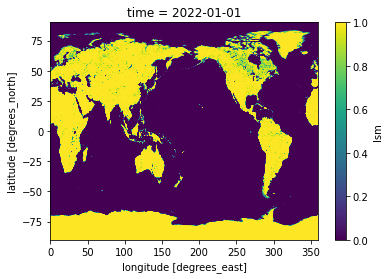

In [25]:
mask.plot()

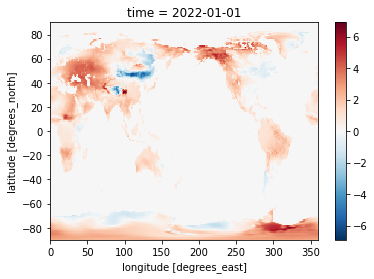

In [23]:
(xds_anomaly["t2a"].sel(time="2023-11-01")*mask).plot()